# (2) Differential expression analysis
---
Michaël Pierrelée, Aix Marseille Univ, CNRS, IBDM, UMR7288, FRANCE - michael.pierrelee@univ-amu.fr

*Apache License 2.0*

---

Differential expression analysis is performed first using a standard DESeq2 workflow (DESeq normalization ([Anders 2010](https://doi.org/10.1186/gb-2010-11-10-r106)) -> GLM statistical test)  and second using SVCD normalization ([Roca 2017](https://doi.org/10.1038/srep42460)) followed by DESeq2 GLM test.

Raw counts are rounded to the closest integer and the genes without one count across samples are filtered out.

SVCD requires to exclude lowly expressed genes in order to calculate normalization factors from genes identified as non-varying by the algorithm. The count threshold is computed to remove 25% of genes with the lowest gene expression mean. For this dataset, it gave a cutoff at around 60 counts. As needed by SVCD, the filtered matrix is converted into log2-base before normalization and the offsets are then converted back into decimal base before to be assigned to the DESeqDataSet object.

For pairwise comparisons, design matrix is made by grouping replicates from each condition into one individual group. To compute the interaction term, e.g. what is the difference between the dysregulations at the E and S phases, the design is `~medium + phase + medium:phase` by assuming that the medium is the first parameter explaining the variations.

Finally, the exported results have the average SVCD-normalized counts between replicates for each condition.

*NB: SVCD normalization does not return exact offsets, so the results are sligty different at each run. To avoid any problem, the result export is commented.*

## Input
* `data/Trinity_genes.gene.counts.matrix`: raw counts from read quantification per gene by RSEM.
* `data/sample_files.tsv`: description of the experimental design.

## Output

Results from DESeq2 (within `data/dea_results`):
* `deseq-ME_vs_FE.csv` and `deseq-MS_vs_FS.csv`: samples from marine water M vs. fresh water F at exponential phase (E) and stationary phase (S) (resp.), using DESeq2 standard workflow;
* `deseq2-size_factors.csv`: size factors from DESeq2 normalization step;
* `deseq2-normalized_counts.csv`: normalized counts after DESeq2 normalization step;
* `svcd-ME_vs_FE.csv` and `svcd-MS_vs_FS.csv`: same as for DESeq2, using SVCD replacing DESeq2 normalization step;
* `svcd-interaction_term.csv`: test if medium effect is different across phase, using SVCD workflow;
* `svcd-normalized_counts.csv` and `svcd-mean_norm_counts.csv`: normalized counts and their means in each condition, from SVCD workflow;
* `svcd-offsets.csv`: normalization factors from SVCD normalization step.

In [1]:
suppressMessages(library( "DESeq2" ))
suppressMessages(library( "cdnormbio" ))
library("BiocParallel")
register(MulticoreParam(16))

## Data

In [2]:
# table of raw counts
rawCounts = read.csv( "../data/Trinity_genes.gene.counts.matrix", header=T, row.names=1, sep = '\t'  )
print( colnames(rawCounts) )

# sample files
sample_files = read.csv( "../data/sample_files.tsv", header=F, sep = '\t' )
print( sample_files$V1 )

# rename column names
colnames( rawCounts ) = sample_files$V3

# colData
medium = sample_files$V4
phase = sample_files$V5
ind = paste( medium, phase, sep='' )

chloInfoTable = data.frame( replicates = colnames( rawCounts ), ind = ind, medium = medium, phase = phase )

print( paste('number of genes:', dim(rawCounts)[1]) )

 [1] "TN1610R1293.1" "TN1610R1293"   "TN1610R1294"   "TN1610R1295"  
 [5] "TN1610R1296"   "TN1610R1297"   "TN1610R1299.1" "TN1610R1299.2"
 [9] "TN1610R1299"   "TN1610R1301"   "TN1610R1302"   "TN1610R1303"  
 [1] TN1610R1293-1 TN1610R1293   TN1610R1294   TN1610R1295   TN1610R1296  
 [6] TN1610R1297   TN1610R1299-1 TN1610R1299-2 TN1610R1299   TN1610R1301  
[11] TN1610R1302   TN1610R1303  
12 Levels: TN1610R1293 TN1610R1293-1 TN1610R1294 TN1610R1295 ... TN1610R1303
[1] "number of genes: 57640"


## Filter

In [3]:
# round
chloCountTable = round( rawCounts, 0 )
# remove integers with null expression
chloCountTable = chloCountTable[ rowSums( chloCountTable ) > 1, ]
# convert to integers
chloCountTable = as.data.frame( lapply( chloCountTable, as.integer ), row.names = row.names(chloCountTable) )

print( paste('number of genes:', dim(chloCountTable)[1]) )
print( paste('number of filtered genes:', dim(rawCounts)[1] - dim(chloCountTable)[1]) )

[1] "number of genes: 52770"
[1] "number of filtered genes: 4870"


## DEA by DESeq2
Normalization and statistical tests were both performed by DESeq2 using standard worflow.

In [4]:
# normalization
dds = DESeqDataSetFromMatrix( countData = chloCountTable, colData = chloInfoTable, design = ~ind )
dds = DESeq( dds, quiet = TRUE, parallel = TRUE )

```R
# export
write.csv( dds$sizeFactor, '../data/dea_results/deseq2-size_factors.csv' )
```

In [5]:
# individual comparisons
resE = results( dds, contrast = c( 'ind', 'ME', 'FE' ), parallel = TRUE )
resS = results( dds, contrast = c( 'ind', 'MS', 'FS' ), parallel = TRUE )

In [14]:
summary(resE)


out of 52770 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4266, 8.1%
LFC < 0 (down)     : 5086, 9.6%
outliers [1]       : 10257, 19%
low counts [2]     : 13237, 25%
(mean count < 7)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [15]:
summary(resS)


out of 52770 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3082, 5.8%
LFC < 0 (down)     : 8327, 16%
outliers [1]       : 10257, 19%
low counts [2]     : 13237, 25%
(mean count < 7)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



```R
# export
write.csv( resE, '../data/dea_results/deseq2-ME_vs_FE.csv' )
write.csv( resS, '../data/dea_results/deseq2-MS_vs_FS.csv' )
```

In [6]:
# mean of counts for each condition
deseq_norm_counts = counts(dds, normalized=TRUE)

```R
# export
write.csv( deseq_norm_counts, '../data/dea_results/deseq2-normalized_counts.csv' )
```

## Normalization by SVCD and tests by DESeq2

In [7]:
# raw data filtering
cct = chloCountTable[ apply(chloCountTable, 1, FUN=min) >= 1 & rowMeans(chloCountTable) >= quantile(rowMeans(chloCountTable), .25), ]
print( paste( 'count threshold:', quantile( rowMeans(chloCountTable), .25) ) )

# normalization function
res.svcd = normalize.svcd( as.matrix(log2( cct )), chloInfoTable$ind )
offsets = res.svcd$offset

# individual comparisons
dds = DESeqDataSetFromMatrix( countData = chloCountTable, colData = chloInfoTable, design = ~ind )
sizeFactors( dds ) = 2^offsets
dds = DESeq( dds, quiet = TRUE, parallel = TRUE )

resE = results( dds, contrast = c( 'ind', 'ME', 'FE' ), parallel = TRUE )
resS = results( dds, contrast = c( 'ind', 'MS', 'FS' ), parallel = TRUE )

[1] "count threshold: 5.91666666666667"


In [8]:
summary(resE)


out of 52770 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4266, 8.1%
LFC < 0 (down)     : 5086, 9.6%
outliers [1]       : 10257, 19%
low counts [2]     : 13237, 25%
(mean count < 7)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [9]:
summary(resS)


out of 52770 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3082, 5.8%
LFC < 0 (down)     : 8327, 16%
outliers [1]       : 10257, 19%
low counts [2]     : 13237, 25%
(mean count < 7)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



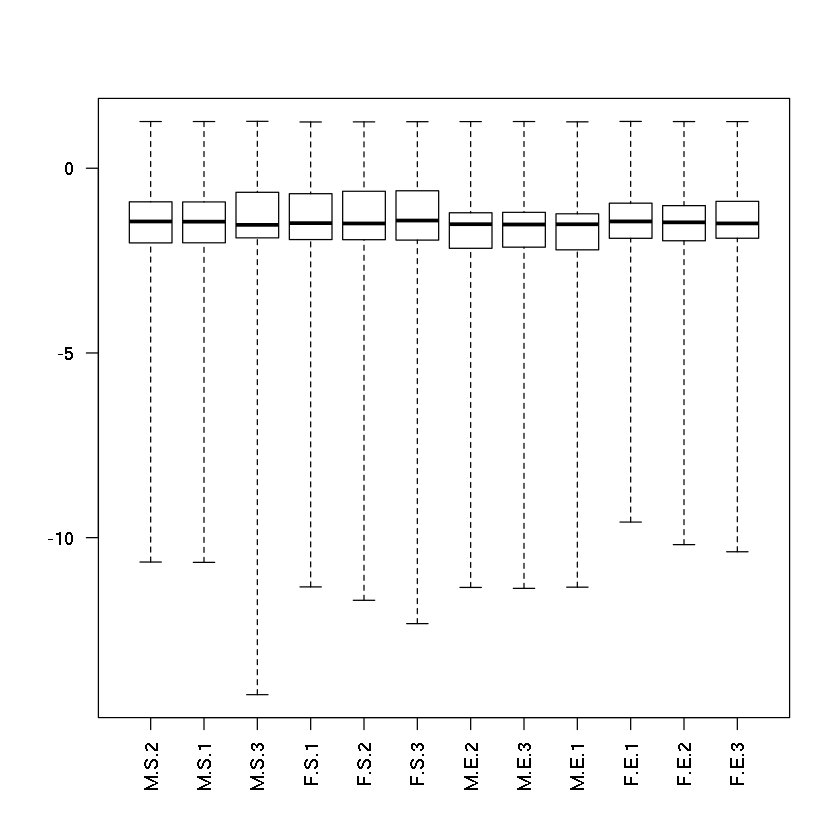

In [10]:
boxplot(log10(assays(dds)[["cooks"]]), range=0, las=2)

In [11]:
# interaction factor
dds = DESeqDataSetFromMatrix( countData = chloCountTable, colData = chloInfoTable,
                              design = ~medium + phase + medium:phase )
sizeFactors( dds ) = 2^offsets
dds = DESeq( dds, quiet = TRUE, parallel = TRUE )

resIT = results(dds, name = 'mediumM.phaseS', parallel = TRUE )

In [12]:
summary(resIT)


out of 52770 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1359, 2.6%
LFC < 0 (down)     : 3795, 7.2%
outliers [1]       : 10266, 19%
low counts [2]     : 17152, 33%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [13]:
# mean of counts for each condition
norm_counts = counts(dds, normalized=TRUE)
mean_counts = list()
for( cond in c('F.E', 'F.S', 'M.E', 'M.S') ){
    # list the replicates
    reps = paste( cond, c(1,2,3), sep='.')
    # make the mean of counts
    mean_counts[[cond]] = rowMeans( norm_counts[ , reps ] )
}
mean_counts = data.frame( mean_counts )

```R
# export
write.csv( offsets, '../data/dea_results/svcd-offsets.csv' )
write.csv( resE, '../data/dea_results/svcd-ME_vs_FE.csv' )
write.csv( resS, '../data/dea_results/svcd-MS_vs_FS.csv' )
write.csv( resIT, '../data/dea_results/svcd-interaction_term.csv' )
write.csv( norm_counts, '../data/dea_results/svcd-normalized_counts.csv' )
write.csv( mean_counts, '../data/dea_results/svcd-mean_norm_counts.csv' )
```